In [1]:
import os
from itertools import chain

import pandas as pd
import numpy as np

from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier

from tqdm import tqdm_notebook

In [2]:
roles = pd.read_csv('../../data/edo_enron-custodians-data.tsv', header=None, names=['user_id','email','name', 'role'], usecols=['email', 'role'], delimiter='\t')
roles = roles.fillna('Regular employee')
roles.role = roles.role.str.split(',').map(lambda r: [i.strip() for i in r])
roles.head(15)

email                                      role
0     philip.allen@enron.com                        [Regular employee]
1      john.arnold@enron.com                          [Vice President]
2   harpreet.arora@enron.com                          [Vice President]
3    robert.badeer@enron.com                                [Director]
4     susan.bailey@enron.com                        [Regular employee]
5        eric.bass@enron.com                                  [Trader]
6     don.baughman@enron.com                                  [Trader]
7       sally.beck@enron.com                 [Chief Operating Officer]
8    robert.benson@enron.com                                [Director]
9       lynn.blair@enron.com                        [Regular employee]
10  sandra.brawner@enron.com                                [Director]
11        rick.buy@enron.com  [Manager, Chief Risk Management Officer]
12  larry.campbell@enron.com                        [Regular employee]
13     mike.carson@enron.com                        [Regular employee]
14   michelle.cash@enron.com                        [Regular employee]

In [3]:
roles[roles.role.map(len) > 1]

email  \
11           rick.buy@enron.com   
16     shelley.corman@enron.com   
22     david.delainey@enron.com   
29       daren.farmer@enron.com   
31        john.forney@enron.com   
39       john.giffith@enron.com   
42      mark.haedicke@enron.com   
45       rod.hayslett@enron.com   
51     stanley.horton@enron.com   
52        kevin.hyatt@enron.com   
55     vince.kaminski@enron.com   
56        steven.kean@enron.com   
60     louise.kitchen@enron.com   
62      john.lavorato@enron.com   
68          teb.lokey@enron.com   
107   richard.sanders@enron.com   
114  jeffrey.shankman@enron.com   
115   richard.shapiro@enron.com   
124     james.steffes@enron.com   
125  joe.stepenovitch@enron.com   
146       andy.zipper@enron.com   

                                                  role  
11            [Manager, Chief Risk Management Officer]  
16                [Vice President, Regulatory Affairs]  
22   [CEO, Enron North America and Enron Energy Ser...  
29                        [Manager, Logistics Manager]  
31                   [Manager, Real-Time Trading Desk]  
39                       [Managing Director, MD of UK]  
42               [Managing Director, Legal Department]  
45   [Vice President, Chief Financial Officer and T...  
51                     [President, Enron Gas Pipeline]  
52                       [Director, Pipeline Business]  
55                     [Manager, Risk Management Head]  
56   [Vice President, Vice President & Chief of Staff]  
60                           [President, Enron Online]  
62                                [CEO, Enron America]  
68                       [Manager, Regulatory Affairs]  
107         [Vice President, Enron Wholesale Services]  
114                  [President, Enron Global Markets]  
115               [Vice President, Regulatory Affairs]  
124               [Vice President, Government Affairs]  
125  [Vice President, Energy Marketing and Trading ...  
146                     [Vice President, Enron Online]

In [4]:
roles.loc[125].role

['Vice President', 'Energy Marketing and Trading Florida']

### Unique roles

In [5]:
set(chain(*roles.role))

{'Administrative Assistant',
 'Analyst Risk Management',
 'CEO',
 'Cash Analyst',
 'Chief Financial Officer and Treasurer',
 'Chief Operating Officer',
 'Chief Risk Management Officer',
 'Director',
 'Energy Marketing and Trading Florida',
 'Enron America',
 'Enron Gas Pipeline',
 'Enron Global Markets',
 'Enron North America and Enron Energy Services',
 'Enron Online',
 'Enron Wholesale Services',
 'General Counsel',
 'Government Affairs',
 'Government Relation Executive',
 'In House Lawyer',
 'Legal Department',
 'Logistics Manager',
 'MD of UK',
 'Manager',
 'Managing Director',
 'Pipeline Business',
 'President',
 'Real-Time Trading Desk',
 'Regular employee',
 'Regulatory Affairs',
 'Risk Management Head',
 'Senior Analyst',
 'Senior Analyst Cash',
 'Senior Specialist',
 'Specialist',
 'Sr. Specialist',
 'Trader',
 'Trading',
 'Vice President',
 'Vice President & Chief of Staff'}

### Prepare data

In [6]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(roles.role)

Y = multilabel_binarizer.transform(roles.role)
roles['labels'] = list(Y)

roles.head(15)

email                                      role  \
0     philip.allen@enron.com                        [Regular employee]   
1      john.arnold@enron.com                          [Vice President]   
2   harpreet.arora@enron.com                          [Vice President]   
3    robert.badeer@enron.com                                [Director]   
4     susan.bailey@enron.com                        [Regular employee]   
5        eric.bass@enron.com                                  [Trader]   
6     don.baughman@enron.com                                  [Trader]   
7       sally.beck@enron.com                 [Chief Operating Officer]   
8    robert.benson@enron.com                                [Director]   
9       lynn.blair@enron.com                        [Regular employee]   
10  sandra.brawner@enron.com                                [Director]   
11        rick.buy@enron.com  [Manager, Chief Risk Management Officer]   
12  larry.campbell@enron.com                        [Regular employee]   
13     mike.carson@enron.com                        [Regular employee]   
14   michelle.cash@enron.com                        [Regular employee]   

                                               labels  
0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  
4   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
6   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
8   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  
9   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
10  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  
11  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
12  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
13  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
14  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

### Load and extract embeddings

In [7]:
files = {
    'Node2vec': 'n2v-emb',
    'ENE': 'edge-emb',
    'ENE neigh. only': 'edge-n-only-emb',

#     'concat': 'edge-emb2',
#     'average': 'average',
#     'hadamard': 'hadamard'
    
#     'Common Loss' : 'combined-tests/0.8'
#     'Distribution BCE': 'edge-dist-emb',
#     'Distribution MSE': 'edge-emb-dist-mse',

#     'Direct Embedding': 'edge-emb-direct-mail-emb',
#     'Direct Embedding Mean': 'edge-emb-direct-mail-emb-mean',
    
#     'edge comb. loss': 'edge-combined-emb',
#     'edge comb. loss; dist': 'edge-combined-dist-emb',
    
#     'edge-label as node-label': 'edge-atnode-combined-emb',
    
#     'node2vec link pred': 'enron-link-prediction/n2v-emb',
#     'edge link pred': 'enron-link-prediction/edge-emb',
#     'edge trw link pred': 'enron-link-prediction/edge-emb-trw',
#     'ENE edge label only': 'enron-link-prediction/edge-emb-topic-only'
    
#     'internodes': 'internodes-emb',
}

EMBEDDINGS_DIR = './data'

embeddings = { k: KeyedVectors.load_word2vec_format(os.path.join(EMBEDDINGS_DIR, f'{v}.vec'))
               for k, v in files.items() }
embeddings

{'Node2vec': <gensim.models.keyedvectors.Word2VecKeyedVectors at 0x7f24edf50a90>,
 'ENE': <gensim.models.keyedvectors.Word2VecKeyedVectors at 0x7f24ededc550>,
 'ENE neigh. only': <gensim.models.keyedvectors.Word2VecKeyedVectors at 0x7f24ede60908>}

In [8]:
mail2id = {mail: str(i) for i, mail in zip(roles.index, roles.email)}
id2mail = dict(zip(mail2id.keys(), mail2id.values()))

In [9]:
# embeddings['Node2vec'].wv[mail2id['john.arnold@enron.com']]

In [10]:
for key, embs  in embeddings.items():
    emb_list = []
    
    for email in roles.email:
        node_id = mail2id[email]
        
        node_emb = embs.wv[node_id] if node_id in embs.wv else None
        emb_list.append(node_emb)
        
    roles[key] = emb_list
roles.head()

/home/michal/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


email                role  \
0    philip.allen@enron.com  [Regular employee]   
1     john.arnold@enron.com    [Vice President]   
2  harpreet.arora@enron.com    [Vice President]   
3   robert.badeer@enron.com          [Director]   
4    susan.bailey@enron.com  [Regular employee]   

                                              labels  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            Node2vec  \
0                                               None   
1  [-0.46070522, 0.32932732, -1.1910964, 0.907266...   
2                                               None   
3  [0.0036666119, 0.4845867, 0.07794115, -0.00641...   
4  [0.081027485, -0.21233013, -0.88872135, -0.522...   

                                                 ENE  \
0                                               None   
1  [-0.1766929, -0.0868792, -0.013442395, -0.0750...   
2                                               None   
3  [-0.05620963, 0.058744002, 0.3107465, 0.085702...   
4  [0.0094368365, 0.1548786, -0.011051917, 0.0724...   

                                     ENE neigh. only  
0                                               None  
1  [-0.12804307, -0.11549692, -0.015620673, 0.046...  
2                                               None  
3  [-0.22639868, -0.037831523, -0.0070425966, 0.2...  
4  [-0.070224926, -0.13175388, 0.18997192, 0.1897...

In [11]:
roles.dropna(inplace=True)
roles.head()

email                role  \
1    john.arnold@enron.com    [Vice President]   
3  robert.badeer@enron.com          [Director]   
4   susan.bailey@enron.com  [Regular employee]   
5      eric.bass@enron.com            [Trader]   
6   don.baughman@enron.com            [Trader]   

                                              labels  \
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            Node2vec  \
1  [-0.46070522, 0.32932732, -1.1910964, 0.907266...   
3  [0.0036666119, 0.4845867, 0.07794115, -0.00641...   
4  [0.081027485, -0.21233013, -0.88872135, -0.522...   
5  [-0.35408014, 0.8270841, 0.98878795, -0.597417...   
6  [-0.19188479, 0.7008465, -0.08144698, -0.52052...   

                                                 ENE  \
1  [-0.1766929, -0.0868792, -0.013442395, -0.0750...   
3  [-0.05620963, 0.058744002, 0.3107465, 0.085702...   
4  [0.0094368365, 0.1548786, -0.011051917, 0.0724...   
5  [-0.2325128, 0.28276348, 0.0049607567, 0.01125...   
6  [-0.13390954, -0.076488495, 0.24436834, 0.1204...   

                                     ENE neigh. only  
1  [-0.12804307, -0.11549692, -0.015620673, 0.046...  
3  [-0.22639868, -0.037831523, -0.0070425966, 0.2...  
4  [-0.070224926, -0.13175388, 0.18997192, 0.1897...  
5  [-0.11769293, 0.024980811, 0.12186611, 0.11819...  
6  [-0.16930176, -0.11675165, -0.29737845, 0.0591...

#### Combination of independent embeddings

In [12]:
# neigh_topic_concat = np.hstack((np.stack(roles['ENE enh. neigh. only']), np.stack(roles['ENE edge label only'])))

# from sklearn.decomposition import PCA

# pca = PCA(n_components=128)
# lower_dim_neigh_topic = pca.fit_transform(neigh_topic_concat)

# roles['neigh. + edge'] = list(neigh_topic_concat)
# embeddings['neigh. + edge'] = None

# roles['PCA(neigh. + edge)'] = list(lower_dim_neigh_topic)
# embeddings['PCA(neigh. + edge)'] = None

### Evaluate on dataset

In [13]:
Y = np.stack(roles.labels.values)

In [14]:
# disable warning (often certain label does not appear in train test)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [15]:
test_size = .2
results = []

for embedding_name in tqdm_notebook(embeddings.keys()):

    X = np.stack(roles[embedding_name])
    
    x_train, x_test, y_train, y_test = train_test_split(X, 
                                                        Y, 
                                                        test_size=test_size, 
                                                        random_state=42)
    lr = LogisticRegression(solver='lbfgs')

    clf = OneVsRestClassifier(lr)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)

    loss = hamming_loss(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    cv_score = np.mean(
        cross_val_score(clf, X, Y, cv=5, scoring='accuracy', n_jobs=-1)
    )

    results.append([embedding_name, loss, acc, cv_score])
    
results_df = pd.DataFrame(results, columns=['Embedding', 'Hamming Loss', 'Accuracy', 'CV accuracy'])
results_df

Embedding  Hamming Loss  Accuracy  CV accuracy
0         Node2vec      0.031558  0.192308     0.265231
1              ENE      0.025641  0.307692     0.336615
2  ENE neigh. only      0.026627  0.269231     0.274154

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

sns.barplot(y='Embedding', x='CV accuracy', data=results_df, ax=ax1)
sns.barplot(y='Embedding', x='CV accuracy', data=results_df, ax=ax2)

ax2.set_xscale('log')
ax2.set_yticklabels([])
ax2.set_ylabel(None)
ax2.set_xlabel('log scale accuracy')

Text(0.5, 0, 'log scale accuracy')

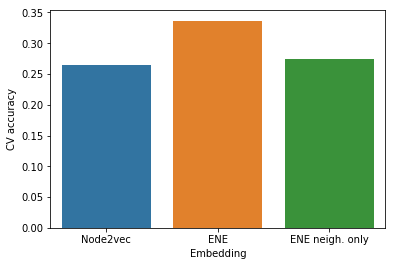

In [17]:
fig, ax = plt.subplots()
sns.barplot(x='Embedding', y='CV accuracy', data=results_df, ax=ax)